# SF CRIME DATA KAGGLE EXPLORATION AND FEATURE ENGINEERING

Dataset contains incidents derived from SFPD Crime Incident Reporting system. The data ranges from 1/1/2003 to 5/13/2015. The training set and test set rotate every week, meaning week 1,3,5,7... belong to test set, week 2,4,6,8 belong to training set.

**Data fields**:

Dates - timestamp of the crime incident

Category - category of the crime incident (only in train.csv). This is the target variable we are going to predict.

Descript - detailed description of the crime incident (only in train.csv)

DayOfWeek - the day of the week

PdDistrict - name of the Police Department District

Resolution - how the crime incident was resolved (only in train.csv)

Address - the approximate street address of the crime incident

X - Longitude

Y - Latitude

OBJECTIVE: PREDICT CATEGORY OF CRIME BASED ON OTHER FEATURES


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

In [2]:
#python and pkg info
%load_ext watermark
%watermark --m -v -p numpy,pandas,scikit-learn,matplotlib

CPython 3.5.1
IPython 4.2.0

numpy 1.10.4
pandas 0.18.1
scikit-learn 0.17.1
matplotlib 1.5.1

compiler   : MSC v.1900 64 bit (AMD64)
system     : Windows
release    : 7
machine    : AMD64
processor  : Intel64 Family 6 Model 58 Stepping 9, GenuineIntel
CPU cores  : 4
interpreter: 64bit


**Some basic exploration as number of nulls, exploration of output (Category)**

In [3]:
#load data
train = pd.read_csv(".\\dataset\\train.csv")
test = pd.read_csv(".\\dataset\\test.csv")
#shape
print(train.shape)
print(test.shape)
#Check for nulls
print(test.isnull().sum())
print(train.isnull().sum())

(878049, 9)
(884262, 7)
Id            0
Dates         0
DayOfWeek     0
PdDistrict    0
Address       0
X             0
Y             0
dtype: int64
Dates         0
Category      0
Descript      0
DayOfWeek     0
PdDistrict    0
Resolution    0
Address       0
X             0
Y             0
dtype: int64


In [4]:
#Category values
print(train["Category"].unique())
print(len(train["Category"].unique()))
print(train["Category"].value_counts())

['WARRANTS' 'OTHER OFFENSES' 'LARCENY/THEFT' 'VEHICLE THEFT' 'VANDALISM'
 'NON-CRIMINAL' 'ROBBERY' 'ASSAULT' 'WEAPON LAWS' 'BURGLARY'
 'SUSPICIOUS OCC' 'DRUNKENNESS' 'FORGERY/COUNTERFEITING' 'DRUG/NARCOTIC'
 'STOLEN PROPERTY' 'SECONDARY CODES' 'TRESPASS' 'MISSING PERSON' 'FRAUD'
 'KIDNAPPING' 'RUNAWAY' 'DRIVING UNDER THE INFLUENCE'
 'SEX OFFENSES FORCIBLE' 'PROSTITUTION' 'DISORDERLY CONDUCT' 'ARSON'
 'FAMILY OFFENSES' 'LIQUOR LAWS' 'BRIBERY' 'EMBEZZLEMENT' 'SUICIDE'
 'LOITERING' 'SEX OFFENSES NON FORCIBLE' 'EXTORTION' 'GAMBLING'
 'BAD CHECKS' 'TREA' 'RECOVERED VEHICLE' 'PORNOGRAPHY/OBSCENE MAT']
39
LARCENY/THEFT                  174900
OTHER OFFENSES                 126182
NON-CRIMINAL                    92304
ASSAULT                         76876
DRUG/NARCOTIC                   53971
VEHICLE THEFT                   53781
VANDALISM                       44725
WARRANTS                        42214
BURGLARY                        36755
SUSPICIOUS OCC                  31414
MISSING PERSON

**I'll join train and test data to make it easier to work with. I will leave train and test to do some exploration.**

In [5]:
# I join test and train dataset to manipulate both datasets together (fix dates, etc)
print(train.shape)
print(test.shape)
separation = train.shape[0] # use to separate train a test again
all_df = pd.concat([train,test], ignore_index=True)

(878049, 9)
(884262, 7)


**Get dates on different columns**

In [6]:
#dates (get year, month, day and hour). I drop minutes, segs.
all_df["Dates"] = pd.to_datetime(all_df["Dates"])
all_df["year"] = all_df["Dates"].dt.year
all_df["month"] = all_df["Dates"].dt.month
all_df["day"] = all_df["Dates"].dt.day
all_df["hour"] = all_df["Dates"].dt.hour
all_df["min"] = all_df["Dates"].dt.minute # I get min only to check later if it's day or night

** There are some bad values on X,Y. I'll get the longitud and latitud from google maps API and fix those values**

In [7]:
# There are 149
print("---------- X -------------")
print(all_df["X"].describe())
print("\n---------- Y -------------")
print(all_df["Y"].describe())
print("\n--------------\n number of entries to fix:")
print(all_df[(all_df['Y'] == 90)]['Y'].value_counts())
print(all_df[(all_df['Y'] == 90)]['X'].value_counts())

# get latitud for all entries of Y that are 90 from google maps and fix X,Y
import requests
dic_add = {} # to save what we find online
for add in (all_df[(all_df['Y'] == 90)]['Address'].value_counts().index):
    fix_add = add.replace(" ","+")
    url = 'https://maps.googleapis.com/maps/api/geocode/json?address=' + fix_add + ',+San+Francisco,+California,+USA'
    try:        
        response = requests.get(url)
        resp_json_payload = response.json()
        dic_add[add]=(resp_json_payload['results'][0]['geometry']['location'])
    except:
        dic_add[add]='***** Fail !!!! *****'
    if dic_add[add] != '***** Fail !!!! *****':
        all_df.loc[all_df['Address'] == add,'X']  = dic_add[add]['lng']
        all_df.loc[all_df['Address'] == add,'Y']  = dic_add[add]['lat']
#show results gotten from google maps
for k,v in dic_add.items():
    print("Address: {0:45} Status: {1}".format(str(k),str(v)))

# check if it was fixed
print("\n--------------\n number of entries to fix:")
print(all_df[(all_df['Y'] == 90)]['Y'].value_counts())
print(all_df[(all_df['Y'] == 90)]['X'].value_counts())

---------- X -------------
count    1.762311e+06
mean    -1.224227e+02
std      3.067205e-02
min     -1.225136e+02
25%     -1.224330e+02
50%     -1.224165e+02
75%     -1.224070e+02
max     -1.205000e+02
Name: X, dtype: float64

---------- Y -------------
count    1.762311e+06
mean     3.777125e+01
std      4.711145e-01
min      3.770788e+01
25%      3.775239e+01
50%      3.777542e+01
75%      3.778436e+01
max      9.000000e+01
Name: Y, dtype: float64

--------------
 number of entries to fix:
90.0    143
Name: Y, dtype: int64
-120.5    143
Name: X, dtype: int64
Address: FRONT ST / THE EMBARCADERONORTH ST            Status: {'lng': -122.3988494, 'lat': 37.7917936}
Address: 1ST ST / BRANNAN ST                           Status: {'lng': -122.3980714, 'lat': 37.7771386}
Address: GENEVA AV / INTERSTATE280 HY                  Status: {'lng': -122.4194155, 'lat': 37.7749295}
Address: I-280 / PENNSYLVANIA AV                       Status: {'lng': -122.3938823, 'lat': 37.76306599999999}
Address: 

**I load weather info. This data set containts the following info for each day that appears on the training and test sets:**

1) Precipitation average

2) Temperature average

3) Moisture average

4) Wind averege

5) Sunset time (hour and min)

6) Sunrise time (hour and min)


**This information is scraped by the followint script: scrape_climate_info.py from wunderground.com and timeanddate.com**

Once loaded I'll merge the information with training and test data and I'll also calculate when then the crime was commited during the night or day

In [8]:
weather_time_df = pd.read_csv('weather_time.csv')
weather_time_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4607 entries, 0 to 4606
Data columns (total 9 columns):
Dates           4607 non-null object
avg_moist       4607 non-null int64
avg_prec        4607 non-null float64
avg_temp        4607 non-null int64
avg_wind        4607 non-null float64
sunrise_hour    4607 non-null int64
sunrise_min     4607 non-null int64
sunset_hour     4607 non-null int64
sunset_min      4607 non-null int64
dtypes: float64(2), int64(6), object(1)
memory usage: 324.0+ KB


In [9]:
#join weather conditions, sunrise, and sunset
weather_time_df["Dates"] = pd.to_datetime(weather_time_df["Dates"])
weather_time_df['avg_prec'] = pd.to_numeric(weather_time_df['avg_prec'])
weather_time_df["year"] = weather_time_df["Dates"].dt.year
weather_time_df["month"] = weather_time_df["Dates"].dt.month
weather_time_df["day"] = weather_time_df["Dates"].dt.day
weather_time_df["date_st"] = weather_time_df["month"].map(str) + '-' + weather_time_df["day"].map(str) + '-' +  weather_time_df["year"].map(str)
all_df["date_st"] = all_df["month"].map(str) + '-' +  all_df["day"].map(str) + '-' + all_df["year"].map(str)
weather_time_df.drop(["year","month","day","Dates"], axis=1, inplace=True)
all_df = all_df.merge(weather_time_df,on='date_st',how='left')
print(all_df.isnull().sum())

Address              0
Category        884262
Dates                0
DayOfWeek            0
Descript        884262
Id              878049
PdDistrict           0
Resolution      884262
X                    0
Y                    0
year                 0
month                0
day                  0
hour                 0
min                  0
date_st              0
avg_moist            0
avg_prec             0
avg_temp             0
avg_wind             0
sunrise_hour         0
sunrise_min          0
sunset_hour          0
sunset_min           0
dtype: int64


In [10]:
def day_night (row):
    """
    Funtion that will calculate if the crime was commited during the day or the night.
    It adds 20 min to the sunset and subtracts 20 min to the sunrise which is the time
    it needs to get dark, then it calculates when the crime happened.
    """    
    hour = row['hour']
    minute = row['min']
    sunrise_hour = row['sunrise_hour'] 
    sunrise_min = row['sunrise_min'] 
    sunset_hour = row['sunset_hour'] 
    sunset_min = row['sunset_min'] 
    
    if sunrise_min < 20:
        sunrise_min = (sunrise_min - 20) + 60
        sunrise_hour = sunrise_hour - 1
    else:
        sunrise_min = (sunrise_min - 20)
        
    sunset_min = (sunset_min + 20) % 60 
    if sunset_min < 20:
        sunset_hour += 1
        
    if (hour > sunrise_hour) and (hour < sunrise_hour):
        return 0 #day
    elif (hour == sunrise_hour) and (minute < sunrise_min):
        return 1 #night
    elif (hour == sunrise_hour) and (minute > sunrise_min):
        return 0 #day
    elif (hour == sunset_hour) and (minute > sunset_min):
        return 1 #night
    elif (hour == sunset_hour) and (minute < sunset_min):
        return 0 #day
    else:
        return 1 # night
    
all_df["day_night"] = all_df.apply(day_night, axis=1)
all_df.day_night.value_counts()

1    1684372
0      77939
Name: day_night, dtype: int64

In [11]:
# get abs(min-30). SEEN in kaggle scrits !!
all_df['min_30_abs'] = abs(all_df['min'] - 30)

**Feature Eng on Addresses** : getting if it's block, corner and if there is an av involved

In [12]:
all_df["is_block"] = all_df["Address"].map(lambda x: 1 if 'block' in x.lower() else 0) # 1 if block
all_df["is_corner"] = all_df["Address"].map(lambda x: 1 if ' /' in x.lower() else 0) # 1 if corner
all_df["is_av"] = all_df["Address"].map(lambda x: 1 if ' av ' in x.lower() else 0) # 1 if at least one av

** Visualizations to explore the data**

In [13]:
# I separate train and test 
train = all_df[:separation]
test = all_df[separation:]
print(train.shape)
print(test.shape)

(878049, 29)
(884262, 29)


In [14]:
all_df.day_night.value_counts()

1    1684372
0      77939
Name: day_night, dtype: int64

In [15]:
#year 2015 only goes till May:
all_df[all_df["year"]==2015]["month"].value_counts()

3    13518
1    13206
4    12209
2    12036
5     5046
Name: month, dtype: int64

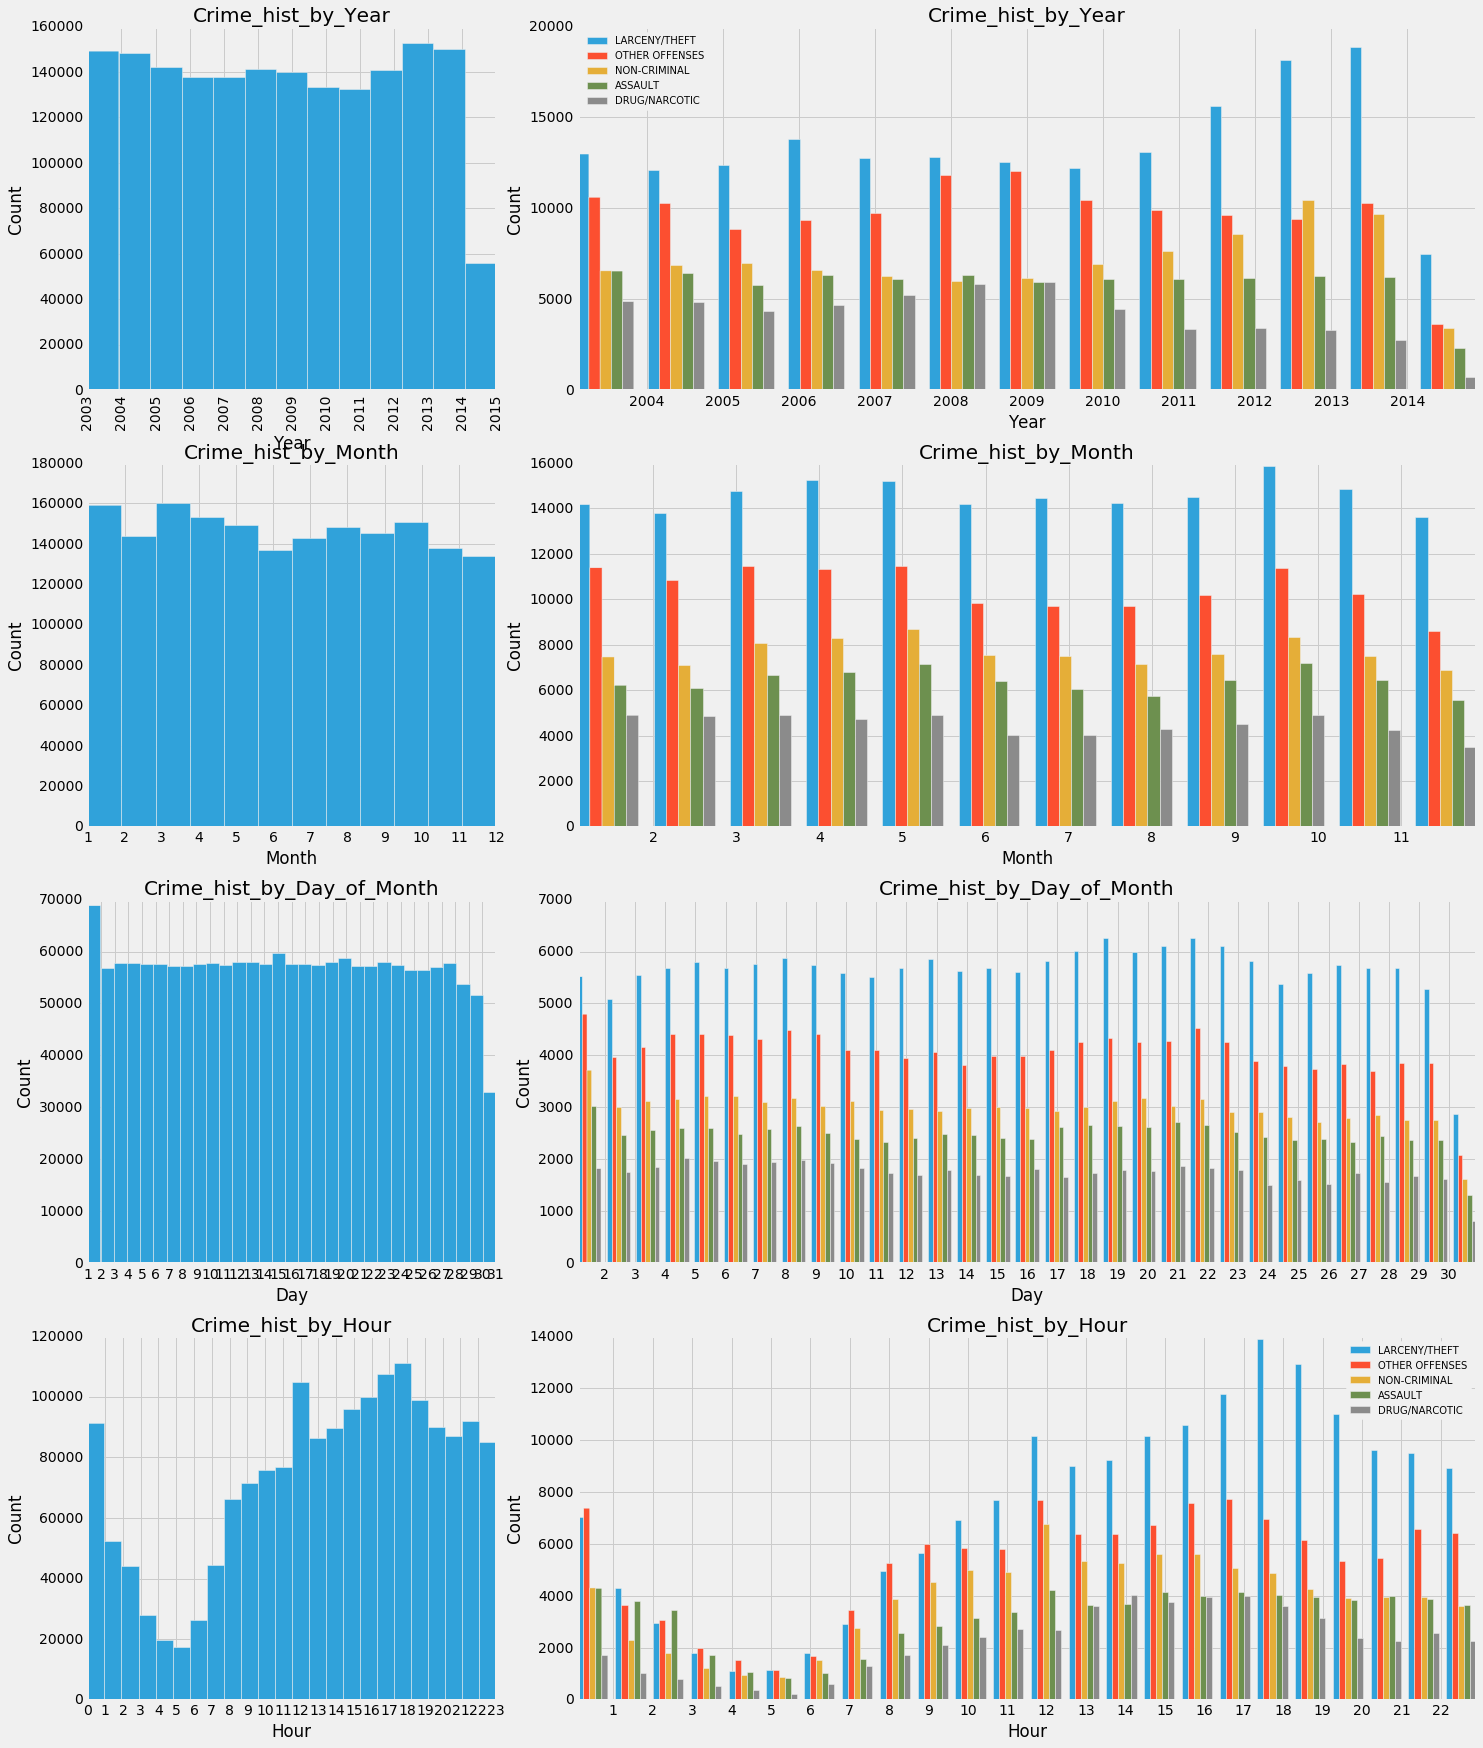

In [16]:
#visualize dates ...
fig = plt.figure(figsize=(30,28))
ax1 = plt.subplot2grid((4,4), (0, 0))
plt.xticks(rotation=90)
ax2 = plt.subplot2grid((4,4), (1, 0))
ax3 = plt.subplot2grid((4,4), (2, 0))
ax4 = plt.subplot2grid((4,4), (3, 0))
ax12 = plt.subplot2grid((4,4), (0, 1),colspan=2)
ax22 = plt.subplot2grid((4,4), (1, 1),colspan=2)
ax32 = plt.subplot2grid((4,4), (2, 1),colspan=2)
ax42 = plt.subplot2grid((4,4), (3, 1),colspan=2)

ax1.set(xticks=range(2003,2016),xlabel='Year' , ylabel='Count', title='Crime_hist_by_Year')
ax2.set(xticks=range(1,13), xlim=(1,12), xlabel='Month' , ylabel='Count', title='Crime_hist_by_Month')
ax3.set(xticks=range(1,32),xlabel='Day' , ylabel='Count', title='Crime_hist_by_Day_of_Month')
ax4.set(xticks=range(0,24),xlabel='Hour' , ylabel='Count', title='Crime_hist_by_Hour')
ax12.set(xticks=range(2003,2016),xlabel='Year' , ylabel='Count', title='Crime_hist_by_Year')
ax22.set(xticks=range(1,13),xlabel='Month' , ylabel='Count', title='Crime_hist_by_Month')
ax32.set(xticks=range(1,32),xlabel='Day' , ylabel='Count', title='Crime_hist_by_Day_of_Month')
ax42.set(xticks=range(0,24),xlabel='Hour' , ylabel='Count', title='Crime_hist_by_Hour')

ax1.hist(all_df["year"], bins=13) 
ax2.hist(all_df["month"], bins =12) 
ax3.hist(all_df["day"], bins=31)
ax4.hist(all_df["hour"], bins=24) 
#ax5 = all_df["DayOfWeek"].value_counts().plot(kind='bar')

hist_category_year = []
hist_category_month = []
hist_category_day = []
hist_category_hour = []
top5cat = train["Category"].value_counts()[:5].index
for category in top5cat:
    hist_category_year.append((train[train["Category"]==category]["year"]).values)
    hist_category_month.append((train[train["Category"]==category]["month"]).values)
    hist_category_day.append((train[train["Category"]==category]["day"]).values)
    hist_category_hour.append((train[train["Category"]==category]["hour"]).values)
     
ax12.hist(hist_category_year,bins=13,label=list(top5cat)) 
ax22.hist(hist_category_month,bins=12) 
ax32.hist(hist_category_day,bins=31)
ax42.hist(hist_category_hour,bins=24,label=list(top5cat)) 

ax12.legend(loc=0,prop={'size':10})
ax42.legend(loc=0,prop={'size':10})

plt.show()

In [17]:
print("Number of addresses with more than one crime: " , len(train["Address"][train["Address"].value_counts().values > 1]))
top10address = train["Address"].value_counts().head(10) # Get first 10
# for each one of these address is there a common crime??? NO!!! 
n_unique_categories = []
for ad in top10address.index:
    n_unique_categories.append(len((train[train["Address"]==ad]["Category"]).unique()))
pd.DataFrame({"Address":top10address.index,"Times": top10address.values, "Number Unique Categories": n_unique_categories})

Number of addresses with more than one crime:  21053


,Address,Number Unique Categories,Times
0,800 Block of BRYANT ST,38,26533
1,800 Block of MARKET ST,34,6581
2,2000 Block of MISSION ST,33,5097
3,1000 Block of POTRERO AV,34,4063
4,900 Block of MARKET ST,30,3251
5,0 Block of TURK ST,28,3228
6,0 Block of 6TH ST,33,2884
7,300 Block of ELLIS ST,31,2703
8,400 Block of ELLIS ST,33,2590
9,16TH ST / MISSION ST,28,2504


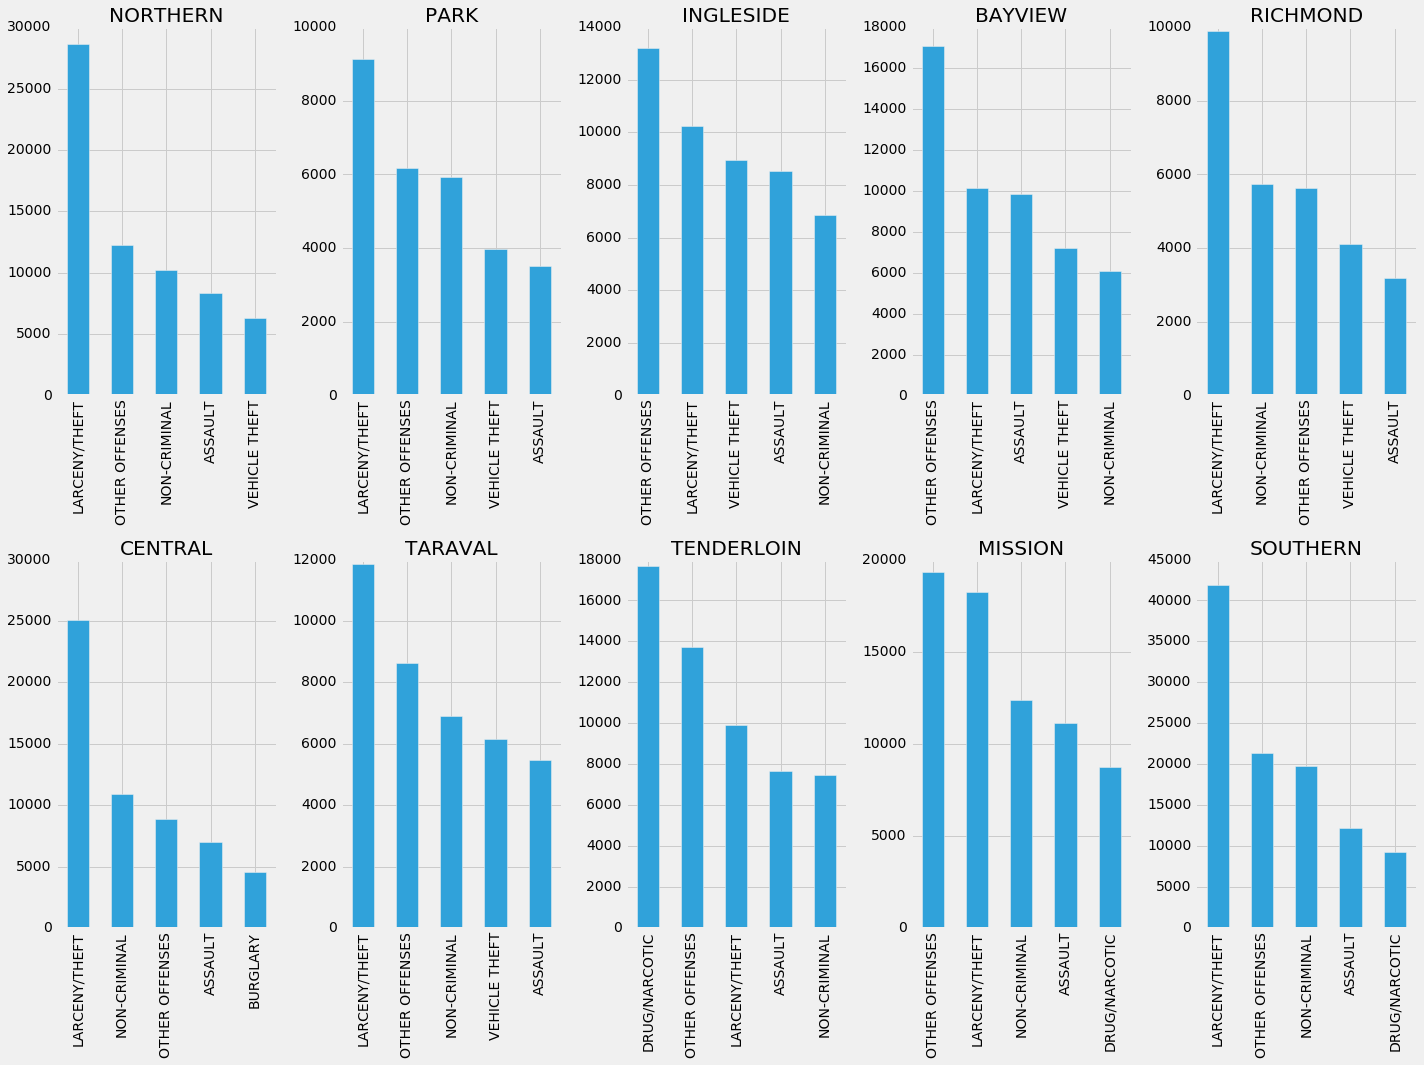

In [18]:
# PdDistrict
#print(train.PdDistrict.value_counts())
districs = train.PdDistrict.unique()

# Visualize type top 10 crimes per discrict
subset_list = []
for d in districs:
    subset_list.append(train[train["PdDistrict"]==d]["Category"])
       
fig = plt.figure(figsize=(20,15))
ax1 = fig.add_subplot(2,5,1)
ax1 = subset_list[0].value_counts()[:5].plot(kind='bar')
ax1.set(title=districs[0])
#plt.xticks(rotation=25)
ax2 = fig.add_subplot(2,5,2)
ax2 = subset_list[1].value_counts()[:5].plot(kind='bar')
ax2.set(title=districs[1])
ax3 = fig.add_subplot(2,5,3)
ax3 = subset_list[2].value_counts()[:5].plot(kind='bar')
ax3.set(title=districs[2])
ax4 = fig.add_subplot(2,5,4)
ax4 = subset_list[3].value_counts()[:5].plot(kind='bar')
ax4.set(title=districs[3])
ax5 = fig.add_subplot(2,5,5)
ax5 = subset_list[4].value_counts()[:5].plot(kind='bar')
ax5.set(title=districs[4])
ax6 = fig.add_subplot(2,5,6)
ax6 = subset_list[5].value_counts()[:5].plot(kind='bar')
ax6.set(title=districs[5])
ax7 = fig.add_subplot(2,5,7)
ax7 = subset_list[6].value_counts()[:5].plot(kind='bar')
ax7.set(title=districs[6])
ax8 = fig.add_subplot(2,5,8)
ax8 = subset_list[7].value_counts()[:5].plot(kind='bar')
ax8.set(title=districs[7])
ax9 = fig.add_subplot(2,5,9)
ax9 = subset_list[8].value_counts()[:5].plot(kind='bar')
ax9.set(title=districs[8])
ax10 = fig.add_subplot(2,5,10)
ax10 = subset_list[9].value_counts()[:5].plot(kind='bar')
ax10.set(title=districs[9])
plt.tight_layout()
plt.show()

**Check how minutes affects Category**

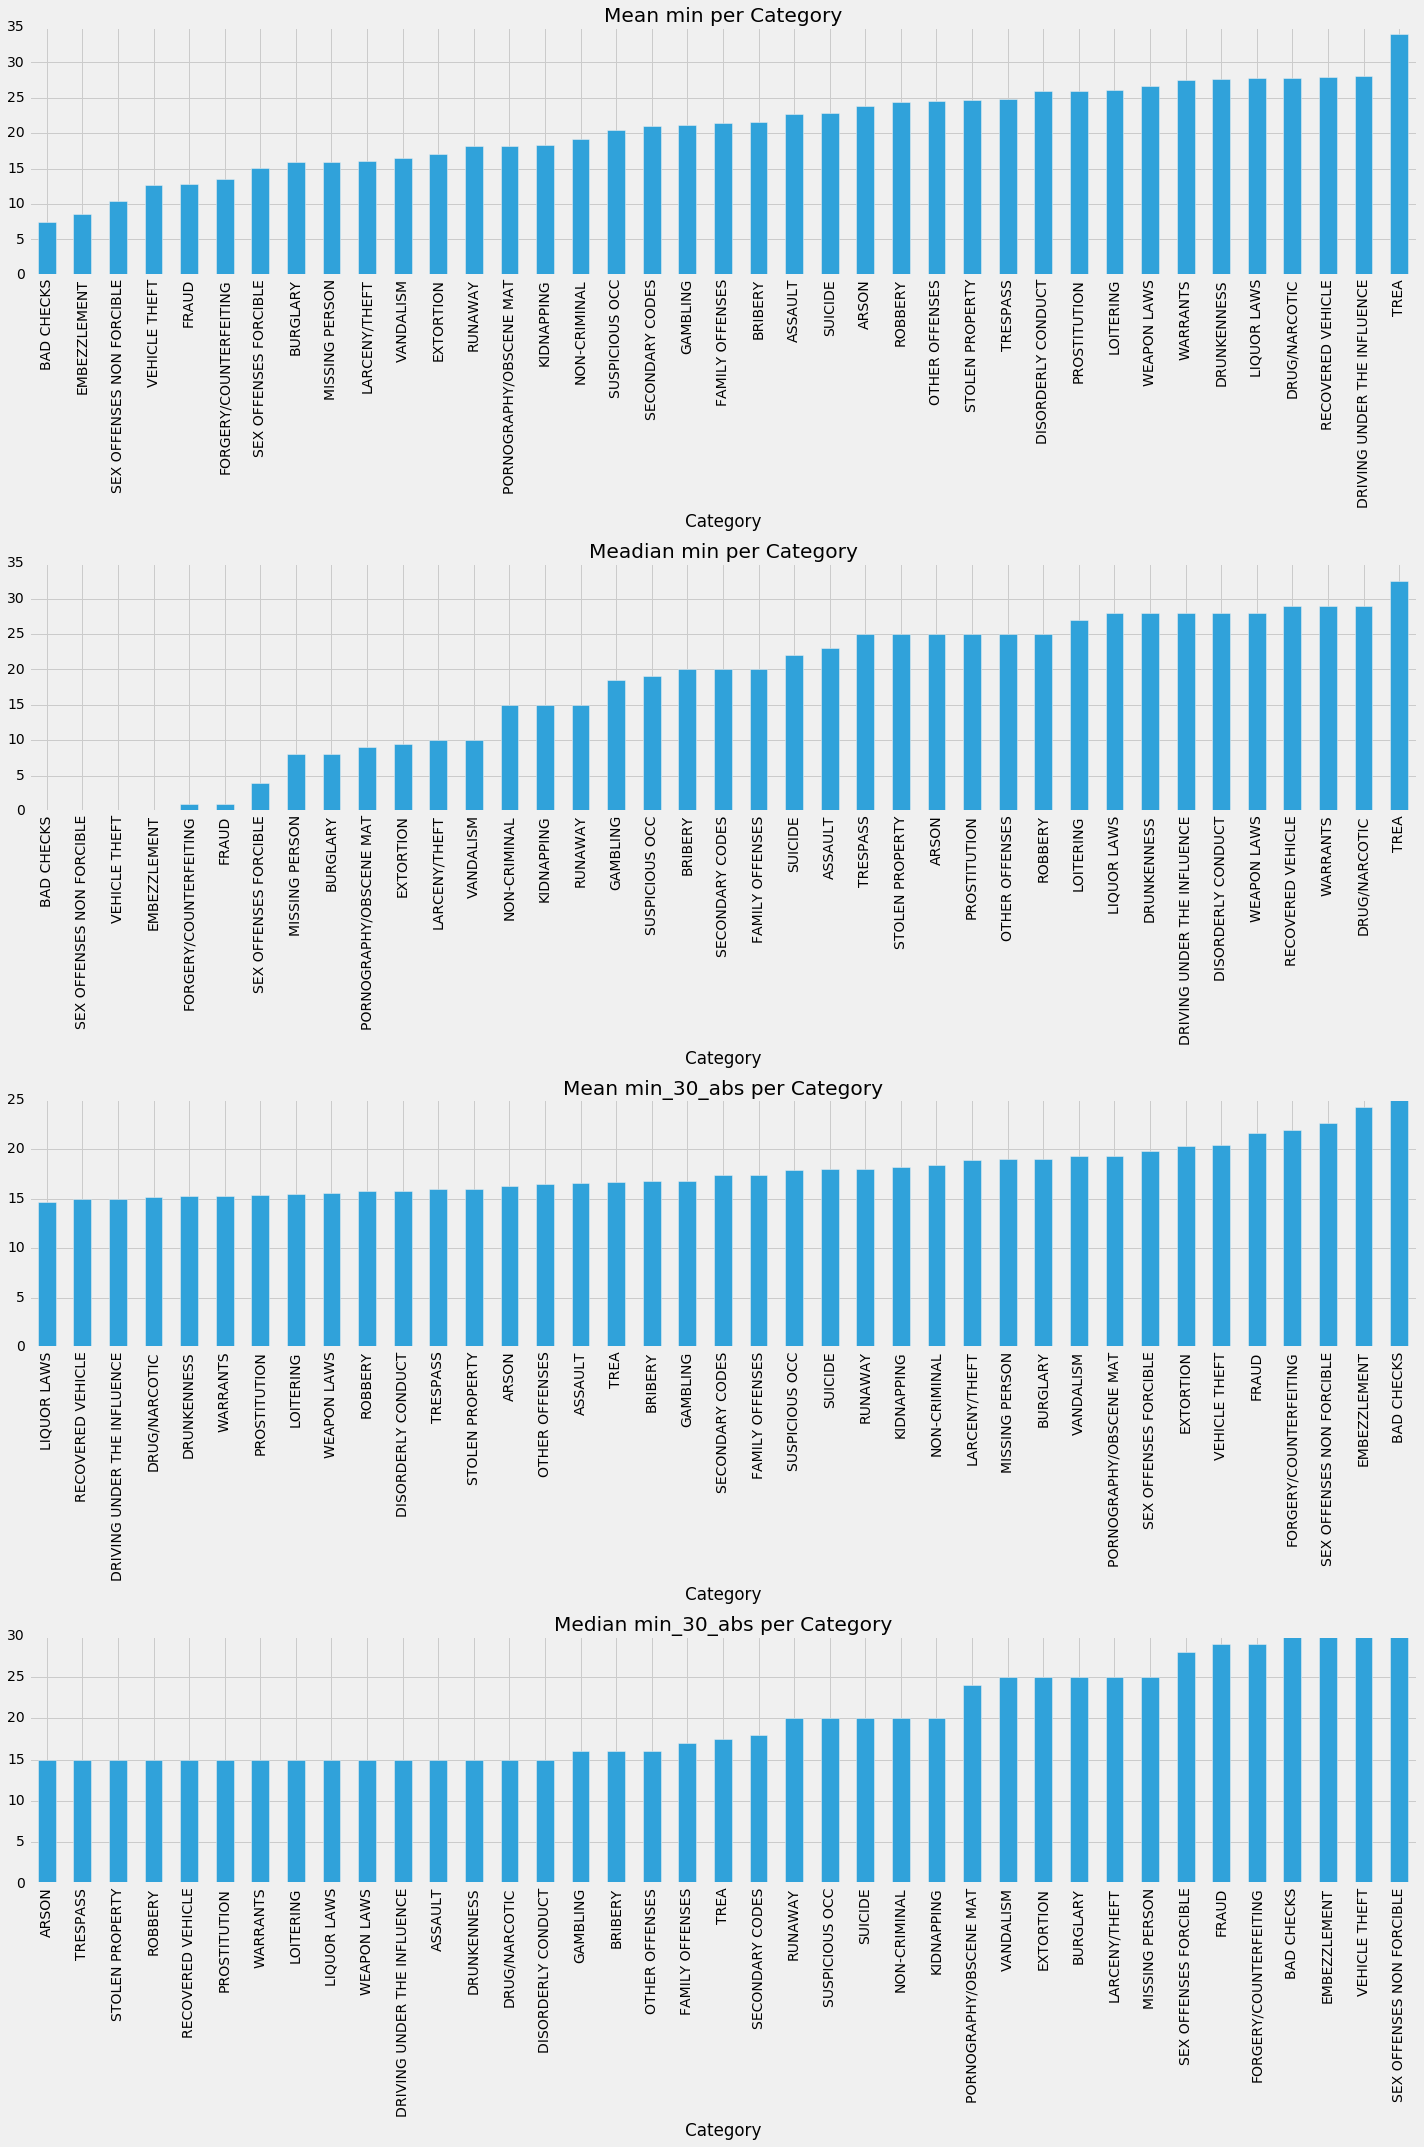

In [19]:
fig = plt.figure(figsize=(20,30))
ax1 = fig.add_subplot(411)
ax1 = pd.pivot_table(train,values='min', index='Category').sort_values().plot(kind='bar')
ax1.set_title("Mean min per Category")
ax12 = fig.add_subplot(412)
ax12 = pd.pivot_table(train,values='min', index='Category',aggfunc='median').sort_values().plot(kind='bar')
ax12.set_title("Meadian min per Category")
ax2 = fig.add_subplot(413)
ax2 = pd.pivot_table(train,values='min_30_abs', index='Category').sort_values().plot(kind='bar')
ax2.set_title("Mean min_30_abs per Category")
ax22 = fig.add_subplot(414)
ax22 = pd.pivot_table(train,values='min_30_abs', index='Category',aggfunc='median').sort_values().plot(kind='bar')
ax22.set_title("Median min_30_abs per Category")
plt.tight_layout()
plt.show()

** Get x_train, y_train and x_test ready for ML **

In [20]:
#I make a copy of all_df becasue I'll be droping columns 
all_df_ml = all_df.copy()
all_df_ml.drop(["Address","Dates","Descript","Resolution","date_st","sunset_hour","sunset_min","sunrise_hour","sunrise_min"], axis=1, inplace=True)
train_ml = all_df_ml[:separation]
train_ml.drop(["Id"], axis=1, inplace=True)
#train_ml.reset_index(inplace=True)
test_ml = all_df_ml[separation:]
test_ml.drop(["Category"], axis=1, inplace=True)

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [21]:
# generate x_train, y_train and x_test for ML
y_train = train_ml["Category"].values
x_train = train_ml.drop("Category",axis=1)
id_test = test_ml["Id"].values
x_test = test_ml.drop("Id",axis=1)
# Save
x_train.to_csv('x_train.csv',index=False)
pd.DataFrame(y_train).to_csv('y_train.csv',index=False)
pd.DataFrame(id_test).to_csv('id_test.csv',index=False)
x_test.to_csv('x_test.csv',index=False)

In [22]:
x_train.head()

,DayOfWeek,PdDistrict,X,Y,year,month,day,hour,min,avg_moist,avg_prec,avg_temp,avg_wind,day_night,min_30_abs,is_block,is_corner,is_av
0,Wednesday,NORTHERN,-122.425892,37.774599,2015,5,13,23,53,44,0.0,59,12.0,1,23,0,1,0
1,Wednesday,NORTHERN,-122.425892,37.774599,2015,5,13,23,53,44,0.0,59,12.0,1,23,0,1,0
2,Wednesday,NORTHERN,-122.424363,37.800414,2015,5,13,23,33,44,0.0,59,12.0,1,3,0,1,1
3,Wednesday,NORTHERN,-122.426995,37.800873,2015,5,13,23,30,44,0.0,59,12.0,1,0,1,0,0
4,Wednesday,PARK,-122.438738,37.771541,2015,5,13,23,30,44,0.0,59,12.0,1,0,1,0,0


In [23]:
x_test.head()

,DayOfWeek,PdDistrict,X,Y,year,month,day,hour,min,avg_moist,avg_prec,avg_temp,avg_wind,day_night,min_30_abs,is_block,is_corner,is_av
878049,Sunday,BAYVIEW,-122.399588,37.735051,2015,5,10,23,59,47,0.0,57,13.0,1,29,1,0,0
878050,Sunday,BAYVIEW,-122.391523,37.732432,2015,5,10,23,51,47,0.0,57,13.0,1,21,0,1,0
878051,Sunday,NORTHERN,-122.426002,37.792212,2015,5,10,23,50,47,0.0,57,13.0,1,20,1,0,0
878052,Sunday,INGLESIDE,-122.437394,37.721412,2015,5,10,23,45,47,0.0,57,13.0,1,15,1,0,0
878053,Sunday,INGLESIDE,-122.437394,37.721412,2015,5,10,23,45,47,0.0,57,13.0,1,15,1,0,0
